## Importing the necessary libraries

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,plot_confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
scaler = MinMaxScaler()
standard_sclaer = StandardScaler()

## Some important functions

In [3]:
def emp_length_mapping(lst):
    mapping = {}
    for elem in lst:
        if elem in ["n/a", "< 1 year"]:
            mapping[elem] = 0
        else:
            mapping[elem] = int(elem.split()[0].strip("+"))
        
    return mapping

In [4]:
def target_mapping(lst):
    mapping = {}
    for elem in lst:
        if elem in ["Default", "Charged Off", "Late (31-120 days)",
                   "Does not meet the credit policy. Status:Charged Off"]:
            mapping[elem] = 1
        else:
            mapping[elem] = 0
    
    return mapping


### Removing the NULLS

In [5]:
def removeNulls(dataframe, axis =1, percent=0.3):
    df = dataframe.copy()
    ishape = df.shape
    if axis == 0:
        rownames = df.transpose().isnull().sum()
        rownames = list(rownames[rownames.values > percent*len(df)].index)
        df.drop(df.index[rownames],inplace=True) 
        print("nNumber of Rows droppedt: ",len(rownames))
    else:
        colnames = (df.isnull().sum()/len(df))
        colnames = list(colnames[colnames.values>=percent].index)
        df.drop(labels = colnames,axis =1,inplace=True)        
        print("Number of Columns droppedt: ",len(colnames))
    print("nOld dataset rows,columns",ishape,"nNew dataset rows,columns",df.shape)
    return df

# Loading the data

In [6]:
current_directory = "/Users/mlabhishek/Documents/Assignment for DS Candidates"
data = pandas.read_csv(r"loan_data.csv")

/Users/mlabhishek/miniforge3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
# NULL values
data.isnull().sum()

id                       0
member_id                0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
                     ...  
all_util            466285
total_rev_hi_lim     70276
inq_fi              466285
total_cu_tl         466285
inq_last_12m        466285
Length: 74, dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [9]:
data.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,4.662850e+05,4.662850e+05,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,4.662810e+05,466285.000000,466256.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,3.960090e+05,0.0,0.0,0.0
mean,1.307973e+07,1.459766e+07,14317.277577,14291.801044,14222.329888,13.829236,432.061201,7.327738e+04,17.218758,0.284678,...,NaN,NaN,NaN,NaN,NaN,NaN,3.037909e+04,NaN,NaN,NaN
std,1.089371e+07,1.168237e+07,8286.509164,8274.371300,8297.637788,4.357587,243.485550,5.496357e+04,7.851121,0.797365,...,NaN,NaN,NaN,NaN,NaN,NaN,3.724713e+04,NaN,NaN,NaN
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN
25%,3.639987e+06,4.379705e+06,8000.000000,8000.000000,8000.000000,10.990000,256.690000,4.500000e+04,11.360000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,1.350000e+04,NaN,NaN,NaN
50%,1.010790e+07,1.194108e+07,12000.000000,12000.000000,12000.000000,13.660000,379.890000,6.300000e+04,16.870000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,2.280000e+04,NaN,NaN,NaN
75%,2.073121e+07,2.300154e+07,20000.000000,20000.000000,19950.000000,16.490000,566.580000,8.896000e+04,22.780000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,3.790000e+04,NaN,NaN,NaN
max,3.809811e+07,4.086083e+07,35000.000000,35000.000000,35000.000000,26.060000,1409.990000,7.500000e+06,39.990000,29.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,9.999999e+06,NaN,NaN,NaN


### Remove columns where NA values are more than or equal to 30%

In [10]:
data = removeNulls(data, axis =1,percent = 0.3)

Number of Columns droppedt:  22
nOld dataset rows,columns (466285, 74) nNew dataset rows,columns (466285, 52)


In [11]:
# remove those columns where more than 1% of the rows for that column contain a null value.
data = data[[label for label in data if data[label].isnull().sum() <= 0.01 * data.shape[0]]]

In [12]:
data.isnull().sum()

id                              0
member_id                       0
loan_amnt                       0
funded_amnt                     0
funded_amnt_inv                 0
term                            0
int_rate                        0
installment                     0
grade                           0
sub_grade                       0
home_ownership                  0
annual_inc                      4
verification_status             0
issue_d                         0
loan_status                     0
pymnt_plan                      0
url                             0
purpose                         0
title                          20
zip_code                        0
addr_state                      0
dti                             0
delinq_2yrs                    29
earliest_cr_line               29
inq_last_6mths                 29
open_acc                       29
pub_rec                        29
revol_bal                       0
revol_util                    340
total_acc     

### Remove all columns with only one unique value.

In [13]:
unique = data.nunique()
unique = unique[unique.values == 1]

In [14]:
data.drop(labels = list(unique.index), axis =1, inplace=True)
print("New shape of the data is :", data.shape , "rows & columns.")

New shape of the data is : (466285, 45) rows & columns.


### Now we have to do something with those NULL values. We can:
    ** remove rows cointain NULL values, **
    ** fill them with median or mode value, **
    ** or use some imputation and try to predict their missing values. **

In [15]:
data = data.dropna()
data.shape[0] / data.shape[0]

1.0

## Removing the non useful columns

In [16]:
data = data.drop(["id", "member_id", "sub_grade", "url", "zip_code", "title"], axis=1)
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq
0,5000,5000,4975.0,36 months,10.65,162.87,B,RENT,24000.0,Verified,...,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,Jan-16,0.0,0.0
1,2500,2500,2500.0,60 months,15.27,59.83,C,RENT,30000.0,Source Verified,...,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.0,0.0
2,2400,2400,2400.0,36 months,15.96,84.33,C,RENT,12252.0,Not Verified,...,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,Jan-16,0.0,0.0
3,10000,10000,10000.0,36 months,13.49,339.31,C,RENT,49200.0,Source Verified,...,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,Jan-15,0.0,0.0
4,3000,3000,3000.0,60 months,12.69,67.79,B,RENT,80000.0,Source Verified,...,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Jan-16,0.0,0.0


In [17]:
# Columns with only one value
for label in list(data):
    if len(data[label].unique()) < 5:
        print(data[label].value_counts())
        print("\n")

 36 months    337250
 60 months    128152
Name: term, dtype: int64


Verified           167792
Source Verified    149765
Not Verified       147845
Name: verification_status, dtype: int64


n    465393
y         9
Name: pymnt_plan, dtype: int64


f    302325
w    163077
Name: initial_list_status, dtype: int64




### # We can see that feature "pymnt_plan" has only two possible values: "n" and "y", but with only 10 occurrences of "y" (less than 1%), so definitely it is insignificant

In [18]:
data = data.drop(["pymnt_plan"], axis=1)
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq
0,5000,5000,4975.0,36 months,10.65,162.87,B,RENT,24000.0,Verified,...,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,Jan-16,0.0,0.0
1,2500,2500,2500.0,60 months,15.27,59.83,C,RENT,30000.0,Source Verified,...,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.0,0.0
2,2400,2400,2400.0,36 months,15.96,84.33,C,RENT,12252.0,Not Verified,...,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,Jan-16,0.0,0.0
3,10000,10000,10000.0,36 months,13.49,339.31,C,RENT,49200.0,Source Verified,...,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,Jan-15,0.0,0.0
4,3000,3000,3000.0,60 months,12.69,67.79,B,RENT,80000.0,Source Verified,...,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Jan-16,0.0,0.0


Text(0.5, 1.0, 'Correlation Matrix (for Loan Status)')

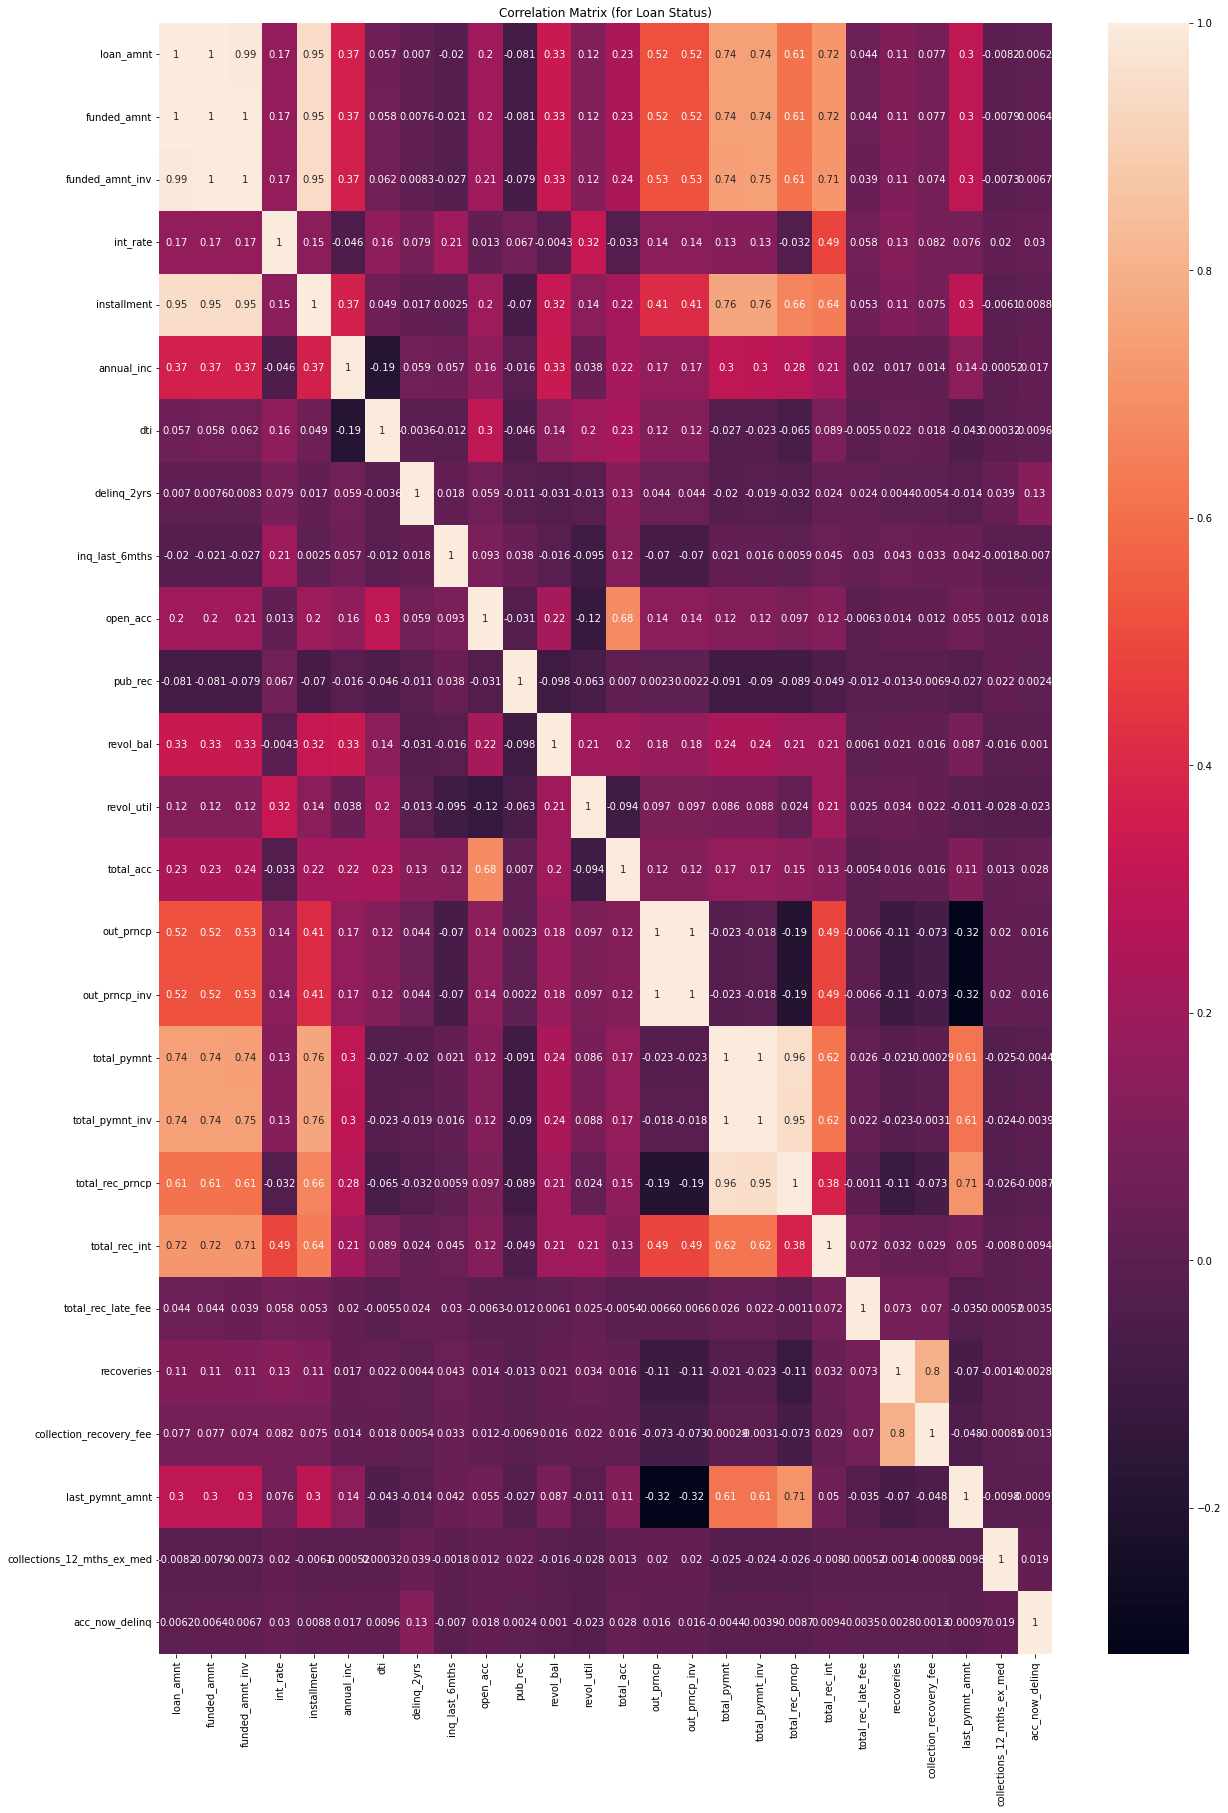

In [19]:
plt.figure(figsize=(20,30))
seaborn.heatmap(data.corr(),annot=True)
plt.title('Correlation Matrix (for Loan Status)')

In [20]:
# Target column
list(data["loan_status"].unique())

['Fully Paid',
 'Charged Off',
 'Current',
 'Default',
 'Late (31-120 days)',
 'In Grace Period',
 'Late (16-30 days)',
 'Does not meet the credit policy. Status:Fully Paid',
 'Does not meet the credit policy. Status:Charged Off']

In [21]:
# Our goal is to prepare predictive model of default. Default client is defined as one with loan_status variable taking on the following levels: 'Charged Off', 'Default', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off'. So this values we will define as ones and the rest as zeros.
data["loan_status"] = data["loan_status"].map(target_mapping(data["loan_status"].unique()))

In [22]:
# let's do something with our non-numerical features!
data.select_dtypes(include=["object"]).head()

,term,grade,home_ownership,verification_status,issue_d,purpose,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d
0,36 months,B,RENT,Verified,Dec-11,credit_card,AZ,Jan-85,f,Jan-15,Jan-16
1,60 months,C,RENT,Source Verified,Dec-11,car,GA,Apr-99,f,Apr-13,Sep-13
2,36 months,C,RENT,Not Verified,Dec-11,small_business,IL,Nov-01,f,Jun-14,Jan-16
3,36 months,C,RENT,Source Verified,Dec-11,other,CA,Feb-96,f,Jan-15,Jan-15
4,60 months,B,RENT,Source Verified,Dec-11,other,OR,Jan-96,f,Jan-16,Jan-16


In [23]:
data["initial_list_status"] = data["initial_list_status"].map({"f": 1, "w": 0})
data["term"] = data["term"].apply(str).str.split().str[0].astype("int")
data["last_pymnt_amnt"] = data["last_pymnt_amnt"].astype("float")
data = pandas.get_dummies(data, columns=list(data.select_dtypes(include=["object"])))

In [24]:
# Convert all continuous variables to numeric values.
numeric_columns = ['loan_amnt','funded_amnt','funded_amnt_inv','installment','int_rate','annual_inc','dti']
data[numeric_columns] = data[numeric_columns].apply(pandas.to_numeric)

In [25]:
data[numeric_columns] = data[numeric_columns].apply(pandas.to_numeric)

### Loan Status: Remove all records with a value of less than 1.5%.

In [26]:
(data.loan_status.value_counts()*100)/len(data)

0    89.147447
1    10.852553
Name: loan_status, dtype: float64

In [27]:
del_loan_status = (data.loan_status.value_counts()*100)/len(data)
del_loan_status = del_loan_status[(del_loan_status < 1.5)]
data.drop(labels = data[data.loan_status.isin(del_loan_status.index)].index, inplace=True)
print("So now we are left with",data.shape ,"rows & columns.")
print(data.loan_status.unique())

So now we are left with (465402, 1060) rows & columns.
[0 1]


In [28]:
X = data.drop('loan_status', axis=1)
y = data['loan_status']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

### scaler is MinMax scaler

In [30]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## CREATING A KNN CLASSIFIER

In [31]:
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [32]:
preds = KNN.predict(X_test) 

In [33]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     62141
           1       0.87      0.37      0.52      7670

    accuracy                           0.92     69811
   macro avg       0.90      0.68      0.74     69811
weighted avg       0.92      0.92      0.91     69811



## CREATING THE XGBOOST MODEL

In [34]:
# fit model to training data
XG_BOOST = XGBClassifier()
XG_BOOST.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [35]:
preds = XG_BOOST.predict(X_test) 

In [36]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     62141
           1       1.00      0.97      0.99      7670

    accuracy                           1.00     69811
   macro avg       1.00      0.99      0.99     69811
weighted avg       1.00      1.00      1.00     69811



/Users/mlabhishek/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


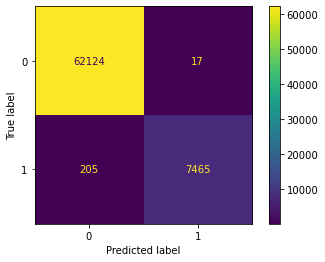

In [37]:
plot_confusion_matrix(XG_BOOST,X_test,y_test)

## CREATING TNE RANDOM FOREST CLASSIFIER

In [38]:
RANDOM_FOREST = RandomForestClassifier(n_estimators=100)
RANDOM_FOREST.fit(X_train,y_train)

RandomForestClassifier()

In [39]:
preds = RANDOM_FOREST.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     62141
           1       1.00      0.95      0.97      7670

    accuracy                           0.99     69811
   macro avg       1.00      0.97      0.98     69811
weighted avg       0.99      0.99      0.99     69811



/Users/mlabhishek/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


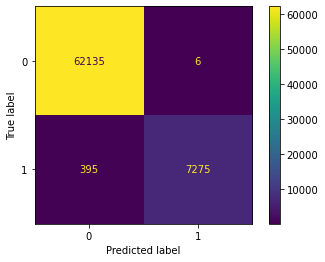

In [40]:
print(classification_report(y_test,preds))
plot_confusion_matrix(RANDOM_FOREST,X_test,y_test)

# ANN NETWORK

In [41]:
ANN = Sequential()

# input layer
ANN.add(Dense(119,  activation='relu'))
ANN.add(Dropout(0.1))

# hidden layer
ANN.add(Dense(78,  activation='relu'))
ANN.add(Dropout(0.1))

# hidden layer
ANN.add(Dense(39, activation='relu'))
ANN.add(Dropout(0.1))

# hidden layer
ANN.add(Dense(19, activation='relu'))
ANN.add(Dropout(0.1))

# output layer
ANN.add(Dense(units=1,activation='sigmoid'))

# Compile model
ANN.compile(loss='binary_crossentropy', optimizer='adam')


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-01 22:01:05.349996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-01 22:01:05.350652: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [42]:
ANN.fit(x=X_train, 
          y=y_train, 
          epochs=10,
          batch_size=256,
          validation_data=(X_test, y_test), 
          )

2022-05-01 22:01:06.359197: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-01 22:01:06.362089: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10
   1/1546 [..............................] - ETA: 10:04 - loss: 0.6741

2022-05-01 22:01:06.600896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1546/1546 [==============================] - ETA: 0s - loss: 0.0688

2022-05-01 22:01:17.898741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1546/1546 [==============================] - 12s 8ms/step - loss: 0.0688 - val_loss: 0.0299
Epoch 2/10
1546/1546 [==============================] - 12s 8ms/step - loss: 0.0301 - val_loss: 0.0278
Epoch 3/10
1546/1546 [==============================] - 12s 8ms/step - loss: 0.0252 - val_loss: 0.0296
Epoch 4/10
1546/1546 [==============================] - 12s 8ms/step - loss: 0.0221 - val_loss: 0.0248
Epoch 5/10
1546/1546 [==============================] - 12s 8ms/step - loss: 0.0198 - val_loss: 0.0268
Epoch 6/10
1546/1546 [==============================] - 12s 8ms/step - loss: 0.0173 - val_loss: 0.0274
Epoch 7/10
1546/1546 [==============================] - 12s 8ms/step - loss: 0.0155 - val_loss: 0.0283
Epoch 8/10
1546/1546 [==============================] - 12s 8ms/step - loss: 0.0136 - val_loss: 0.0328
Epoch 9/10
1546/1546 [==============================] - 12s 8ms/step - loss: 0.0121 - val_loss: 0.0312
Epoch 10/10
1546/1546 [==============================] - 12s 8ms/step - loss: 0.0111

<AxesSubplot:>

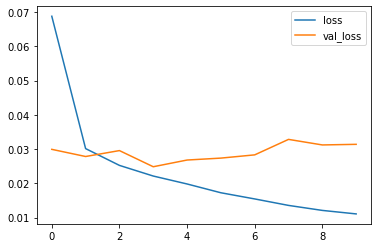

In [43]:
losses = pandas.DataFrame(ANN.history.history)
losses[['loss','val_loss']].plot()

In [44]:
predictions = (ANN.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test,predictions))

2022-05-01 22:03:06.351635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     62141
           1       0.99      0.96      0.97      7670

    accuracy                           0.99     69811
   macro avg       0.99      0.98      0.98     69811
weighted avg       0.99      0.99      0.99     69811



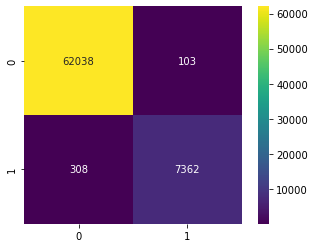

In [45]:
cm = confusion_matrix(y_test,predictions)
plot = sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', square=True) #plot_confusion_matrix does not work directly for ANN

In [46]:
predictions = (ANN.predict(X_test) > 0.7).astype("int32")
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     62141
           1       0.99      0.96      0.97      7670

    accuracy                           0.99     69811
   macro avg       0.99      0.98      0.99     69811
weighted avg       0.99      0.99      0.99     69811

